In [1]:
# data_loader.py

import xarray as xr

class DataLoader:
    def __init__(self, data_path, debug=False):
        """
        Initialize the DataLoader with the path to data and debug flag.

        Parameters:
        - data_path (str): Path to the directory containing NetCDF files.
        - debug (bool): If True, enables detailed print statements for debugging.
        """
        self.data_path = data_path
        self.debug = debug
        self.ssp_files = {
            'SSP1-1.9': 'Selected_hist_ssp119_daily_CMIP6_SIE_SIA.nc',
            'SSP1-2.6': 'Selected_hist_ssp126_daily_CMIP6_SIE_SIA.nc',
            'SSP2-4.5': 'Selected_hist_ssp245_daily_CMIP6_SIE_SIA.nc',
            'SSP3-7.0': 'Selected_hist_ssp370_daily_CMIP6_SIE_SIA.nc',
            'SSP5-8.5': 'Selected_hist_ssp585_daily_CMIP6_SIE_SIA.nc'
        }
        self.ssp_datasets = {}
        self.obs_dataset = None

        if self.debug:
            print("Initialized DataLoader with data path:", self.data_path)

    def load_scenario_datasets(self):
        """Load all scenario datasets."""
        if self.debug:
            print("\nLoading scenario datasets...")
        for scenario_name, filename in self.ssp_files.items():
            try:
                dataset = xr.open_dataset(f"{self.data_path}/{filename}")
                self.ssp_datasets[scenario_name] = dataset
                if self.debug:
                    print(f"Loaded dataset for {scenario_name} from file {filename}")
            except FileNotFoundError:
                if self.debug:
                    print(f"Error: File {filename} not found in {self.data_path}.")
            except Exception as e:
                if self.debug:
                    print(f"Error loading {filename}: {e}")

    def load_observational_dataset(self, filename='NSIDC_CDR_daily_v4_SIA_SIE_197901-202312_no_leap.nc'):
        """Load the observational dataset."""
        if self.debug:
            print("\nLoading observational dataset...")
        try:
            self.obs_dataset = xr.open_dataset(f"{self.data_path}/{filename}")
            if self.debug:
                print(f"Loaded observational dataset from {filename}")
        except FileNotFoundError:
            if self.debug:
                print(f"Error: Observational data file {filename} not found in {self.data_path}.")
        except Exception as e:
            if self.debug:
                print(f"Error loading observational data: {e}")


In [2]:
# data_processor.py

class DataProcessor:
    def __init__(self, data_loader, debug=False):
        """
        Initialize the DataProcessor with a DataLoader instance.

        Parameters:
        - data_loader (DataLoader): Instance of DataLoader containing loaded datasets.
        - debug (bool): If True, enables detailed print statements for debugging.
        """
        self.data_loader = data_loader
        self.debug = debug
        self.ssp_sie_data = {}
        self.obs_sie = None
        self.obs_sie_sep = None
        self.last_obs_year = None

        if self.debug:
            print("Initialized DataProcessor.")

    def extract_sea_ice_extent_variables(self):
        """Extract sea ice extent variables from datasets."""
        if self.debug:
            print("\nExtracting sea ice extent variables...")
        for scenario_name, dataset in self.data_loader.ssp_datasets.items():
            if 'Arctic_SIE' in dataset.variables:
                self.ssp_sie_data[scenario_name] = dataset['Arctic_SIE']
                if self.debug:
                    print(f"Extracted 'Arctic_SIE' for scenario {scenario_name}")
            else:
                if self.debug:
                    print(f"Warning: 'Arctic_SIE' variable not found in dataset for {scenario_name}")
        if self.data_loader.obs_dataset and 'CDR_SIE' in self.data_loader.obs_dataset.variables:
            self.obs_sie = self.data_loader.obs_dataset['CDR_SIE']
            if self.debug:
                print("Extracted 'CDR_SIE' from observational dataset")
        else:
            if self.debug:
                print("Warning: 'CDR_SIE' variable not found in observational dataset")

    def select_september_observational_data(self, start_year='2016-01-01', end_year='2100-12-31'):
        """Select September data from observational dataset within the specified date range."""
        if self.debug:
            print(f"\nSelecting September observational data from {start_year} to {end_year}...")
        if self.obs_sie is not None:
            self.obs_sie_sep = self.obs_sie.sel(time=self.obs_sie['time.month'] == 9)
            self.obs_sie_sep = self.obs_sie_sep.sel(time=slice(start_year, end_year))
            self.last_obs_year = self.obs_sie_sep['time'].dt.year.max().values
            if self.debug:
                print(f"Selected September data: {self.obs_sie_sep.time.size} time points")
        else:
            if self.debug:
                print("Error: Observational sea ice extent data is not loaded.")


In [3]:
# model_pruner.py

import numpy as np
import xarray as xr

class ModelPruner:
    def __init__(self, data_processor, debug=False):
        """
        Initialize the ModelPruner with a DataProcessor instance.

        Parameters:
        - data_processor (DataProcessor): Instance of DataProcessor containing processed datasets.
        - debug (bool): If True, enables detailed print statements for debugging.
        """
        self.data_processor = data_processor
        self.debug = debug
        self.scenario_pruned_data = {}
        self.scenario_pruned_models = {}

        if self.debug:
            print("Initialized ModelPruner.")

    def perform_pruning(self, scenario_name, historical_start='1980-01-01', historical_end='2014-12-31', threshold_multiplier=3):
        """
        Prune models for a specific scenario based on historical data.

        Parameters:
        - scenario_name (str): Name of the scenario.
        - historical_start (str): Start date for historical period.
        - historical_end (str): End date for historical period.
        - threshold_multiplier (float): Multiplier for standard deviation to set pruning threshold.
        """
        if self.debug:
            print(f"\nPerforming pruning for scenario: {scenario_name}")
        if scenario_name not in self.data_processor.ssp_sie_data:
            if self.debug:
                print(f"Error: Sea ice extent data for scenario {scenario_name} not found.")
            return

        scenario_sie_data = self.data_processor.ssp_sie_data[scenario_name]
        scenario_sie_sep = scenario_sie_data.sel(time=scenario_sie_data['time.month'] == 9)
        ensemble_members = scenario_sie_sep['GCM'].values
        models_to_keep = []
        discarded_models = []
        model_names = set(member.split('_')[0] for member in ensemble_members)

        if self.debug:
            print(f"Total models in scenario {scenario_name}: {len(model_names)}")

        # Calculate observational statistics
        if self.data_processor.obs_sie_sep is None:
            if self.debug:
                print("Error: Observational September sea ice extent data is not selected.")
            return

        obs_hist = self.data_processor.obs_sie.sel(time=slice(historical_start, historical_end))
        obs_hist_mean = obs_hist.mean().values.item()
        obs_hist_std = obs_hist.std().values.item()
        if self.debug:
            print(f"Observational historical mean: {obs_hist_mean:.4f}")
            print(f"Observational historical std: {obs_hist_std:.4f}")

        for model_name in model_names:
            members = [member for member in ensemble_members if member.startswith(model_name)]
            keep_model = False
            if self.debug:
                print(f"\nAnalyzing model: {model_name} with {len(members)} ensemble members")
            for member in members:
                member_sie = scenario_sie_sep.sel(GCM=member)
                member_sie_hist = member_sie.sel(time=slice(historical_start, historical_end))

                # Align observational and model historical data
                obs_hist_aligned, member_sie_hist_aligned = xr.align(
                    obs_hist,
                    member_sie_hist,
                    join='inner'
                )

                if obs_hist_aligned.time.size == 0 or member_sie_hist_aligned.time.size == 0:
                    if self.debug:
                        print(f"No overlapping historical time indices for member {member}. Skipping.")
                    continue

                # Calculate mean difference
                model_hist_mean = member_sie_hist_aligned.mean().values.item()
                diff = model_hist_mean - obs_hist_mean
                if self.debug:
                    print(f"Member {member} historical mean: {model_hist_mean:.4f}, Difference: {diff:.4f}")

                if np.abs(diff) <= threshold_multiplier * obs_hist_std:
                    keep_model = True
                    if self.debug:
                        print(f"Model {model_name} meets pruning criteria (|diff| <= {threshold_multiplier}*std). Keeping model.")
                    break  # Keep the model if any member meets the criteria

            if keep_model:
                models_to_keep.extend(members)
                if self.debug:
                    print(f"Model {model_name} kept with {len(members)} ensemble members.")
            else:
                discarded_models.append(model_name)
                if self.debug:
                    print(f"Model {model_name} discarded with {len(members)} ensemble members.")

        total_models = len(model_names)
        pruned_models = len(discarded_models)
        kept_models = total_models - pruned_models
        if self.debug:
            print(f"\nPruning Summary for scenario {scenario_name}:")
            print(f"Total models: {total_models}")
            print(f"Models kept: {kept_models}")
            print(f"Models pruned: {pruned_models}")
            if pruned_models > 0:
                print(f"Discarded models: {', '.join(discarded_models)}")

        pruned_scenario_sie_data = scenario_sie_data.sel(GCM=models_to_keep)
        self.scenario_pruned_data[scenario_name] = pruned_scenario_sie_data
        self.scenario_pruned_models[scenario_name] = pruned_models

        if self.debug:
            print(f"Pruned data for scenario {scenario_name}: {pruned_scenario_sie_data.GCM.size} ensemble members remaining.")


In [4]:
# analyzer.py

import numpy as np
import pandas as pd
import xarray as xr

class Analyzer:
    def __init__(self, data_processor, model_pruner, debug=False):
        """
        Initialize the Analyzer with DataProcessor and ModelPruner instances.

        Parameters:
        - data_processor (DataProcessor): Instance of DataProcessor containing processed datasets.
        - model_pruner (ModelPruner): Instance of ModelPruner containing pruned datasets.
        - debug (bool): If True, enables detailed print statements for debugging.
        """
        self.data_processor = data_processor
        self.model_pruner = model_pruner
        self.debug = debug
        self.scenario_stats = {}

        if self.debug:
            print("Initialized Analyzer.")

    def analyze_scenario(self, scenario_name, use_pruned_data=False):
        """
        Analyze a specific scenario by collecting statistics and preparing data for plotting.

        Parameters:
        - scenario_name (str): Name of the scenario.
        - use_pruned_data (bool): Indicates whether to use pruned data.
        """
        data_label = 'Pruned Data' if use_pruned_data else 'Original Data'
        if self.debug:
            print(f"\nAnalyzing scenario: {scenario_name} ({data_label})")

        # Select appropriate dataset
        if use_pruned_data:
            scenario_sie_sep = self.model_pruner.scenario_pruned_data.get(scenario_name)
            if scenario_sie_sep is None:
                if self.debug:
                    print(f"Error: Pruned data for scenario {scenario_name} not found.")
                return
        else:
            scenario_sie_sep = self.data_processor.ssp_sie_data.get(scenario_name)
            if scenario_sie_sep is None:
                if self.debug:
                    print(f"Error: Sea ice extent data for scenario {scenario_name} not found.")
                return

        scenario_sie_sep = scenario_sie_sep.sel(time=scenario_sie_sep['time.month'] == 9)
        ensemble_members = scenario_sie_sep['GCM'].values

        if not ensemble_members.size:
            if self.debug:
                print(f"No ensemble members left for {scenario_name} after pruning.")
            return

        durations_list, ice_free_counts, member_stats = self.collect_duration_and_counts(
            scenario_name, scenario_sie_sep, ensemble_members
        )

        earliest_member, latest_member = self.find_earliest_and_latest_ice_free_members(
            scenario_sie_sep, ensemble_members
        )

        selected_members = self.select_representative_ensemble_members(scenario_sie_sep)

        # Store statistics
        self.scenario_stats[scenario_name] = {
            'durations_list': durations_list,
            'ice_free_counts': ice_free_counts,
            'member_stats': member_stats,
            'earliest_member': earliest_member,
            'latest_member': latest_member,
            'selected_members': selected_members,
            'use_pruned_data': use_pruned_data
        }

        if self.debug:
            print(f"Analysis completed for scenario {scenario_name} ({data_label})")

    def find_earliest_and_latest_ice_free_members(self, scenario_sie_sep, ensemble_members):
        """
        Identify the earliest and latest ensemble members to reach practically ice-free conditions.

        Parameters:
        - scenario_sie_sep (xarray.DataArray): September sea ice extent data for the scenario.
        - ensemble_members (list): List of ensemble member names.

        Returns:
        - earliest_member (str or None): Name of the earliest ensemble member.
        - latest_member (str or None): Name of the latest ensemble member.
        """
        if self.debug:
            print("\nFinding earliest and latest ice-free members...")
        earliest_pif_year = np.inf
        latest_pif_year = -np.inf
        earliest_member = None
        latest_member = None

        for member in ensemble_members:
            member_sie = scenario_sie_sep.sel(GCM=member)
            pif_year, _ = self.find_ice_free_years_for_member(member_sie)

            if pif_year is not None and 2016 <= pif_year <= 2100:
                if self.debug:
                    print(f"Member {member} reaches practically ice-free in {pif_year}")
                if pif_year < earliest_pif_year:
                    earliest_pif_year = pif_year
                    earliest_member = member
                if pif_year > latest_pif_year:
                    latest_pif_year = pif_year
                    latest_member = member

        if earliest_member:
            if self.debug:
                print(f"Earliest practically ice-free member: {earliest_member} in {int(earliest_pif_year)}")
        else:
            if self.debug:
                print("No member reaches practically ice-free conditions within 2016-2100.")

        if latest_member:
            if self.debug:
                print(f"Latest practically ice-free member: {latest_member} in {int(latest_pif_year)}")
        else:
            if self.debug:
                print("No member reaches practically ice-free conditions within 2016-2100.")

        return earliest_member, latest_member

    def find_ice_free_years_for_member(self, member_sie, practical_threshold=1.0, actual_threshold=0.00001):
        """
        Determine the years when a member reaches practically and actually ice-free conditions.

        Parameters:
        - member_sie (xarray.DataArray): Sea ice extent data for the member.
        - practical_threshold (float): Threshold for practically ice-free condition.
        - actual_threshold (float): Threshold for actually ice-free condition.

        Returns:
        - practical_year (int or None): Year when practically ice-free condition is met.
        - actual_year (int or None): Year when actually ice-free condition is met.
        """
        values = member_sie.values
        times = member_sie['time']
        # Only consider times from 2016 onwards
        valid_indices = np.where(times.dt.year >= 2016)[0]
        if valid_indices.size == 0:
            if self.debug:
                print(f"Member {member_sie['GCM'].values} has no data from 2016 onwards.")
            return None, None

        values = values[valid_indices]
        times = times[valid_indices]

        practical_indices = np.where(values <= practical_threshold)[0]
        actual_indices = np.where(values <= actual_threshold)[0]

        practical_year = times[practical_indices[0]].dt.year.item() if practical_indices.size else None
        if practical_year and not (2016 <= practical_year <= 2100):
            practical_year = None

        actual_year = times[actual_indices[0]].dt.year.item() if actual_indices.size else None
        if actual_year and not (2016 <= actual_year <= 2100):
            actual_year = None

        if practical_year:
            if self.debug:
                print(f"Member {member_sie['GCM'].values} reaches practically ice-free in {practical_year}")
        else:
            if self.debug:
                print(f"Member {member_sie['GCM'].values} never reaches practically ice-free conditions")

        if actual_year:
            if self.debug:
                print(f"Member {member_sie['GCM'].values} reaches actually ice-free in {actual_year}")
        else:
            if self.debug:
                print(f"Member {member_sie['GCM'].values} never reaches actually ice-free conditions")

        return practical_year, actual_year

    def select_representative_ensemble_members(self, scenario_sie_sep):
        """
        Select representative ensemble members based on minimal difference from observations.

        Parameters:
        - scenario_sie_sep (xarray.DataArray): September sea ice extent data for the scenario.

        Returns:
        - selected_members (dict): Dictionary with selected members for each category.
        """
        if self.debug:
            print("\nSelecting representative ensemble members...")
        ensemble_members = scenario_sie_sep['GCM'].values
        selected_members = {'Practically Ice-Free': None, 'Actually Ice-Free': None}
        min_difference = {'Practically Ice-Free': np.inf, 'Actually Ice-Free': np.inf}

        for member in ensemble_members:
            member_sie = scenario_sie_sep.sel(GCM=member)
            member_sie_hist = member_sie.sel(time=slice('2016-01-01', '2100-12-31'))
            obs_sie_aligned, member_sie_hist_aligned = xr.align(
                self.data_processor.obs_sie_sep.sel(time=slice('2016-01-01', '2100-12-31')),
                member_sie_hist,
                join='inner'
            )

            if member_sie_hist_aligned.time.size == 0 or obs_sie_aligned.time.size == 0:
                if self.debug:
                    print(f"No overlapping time indices for member {member}. Skipping.")
                continue

            member_last_value = member_sie_hist_aligned.isel(time=-1).values.mean()
            obs_last_value = obs_sie_aligned.isel(time=-1).values.mean()
            last_diff = abs(member_last_value - obs_last_value)

            pif_year, aif_year = self.find_ice_free_years_for_member(member_sie)

            # Select for Practically Ice-Free
            if pif_year and aif_year:
                category = 'Practically Ice-Free'
                if last_diff < min_difference[category]:
                    min_difference[category] = last_diff
                    selected_members[category] = member
                    if self.debug:
                        print(f"Selected member {member} for Practically Ice-Free with difference {last_diff:.4f}")

        if self.debug:
            print("Selected ensemble members:")
            for category, member in selected_members.items():
                print(f"  {category}: {member}")
        return selected_members

    def collect_duration_and_counts(self, scenario_name, scenario_sie_sep, ensemble_members):
        """
        Collect durations between Practically and Actually Ice-Free conditions and count ice-free conditions.

        Parameters:
        - scenario_name (str): Name of the scenario.
        - scenario_sie_sep (xarray.DataArray): September sea ice extent data for the scenario.
        - ensemble_members (list): List of ensemble member names.

        Returns:
        - durations_list (list): List of dictionaries with durations.
        - ice_free_counts (list): List of dictionaries with counts of ice-free conditions.
        - member_stats (list): List of dictionaries with member statistics.
        """
        if self.debug:
            print(f"\nCollecting durations and counts for scenario {scenario_name}...")
        durations_list = []
        ice_free_counts = []
        no_practical_count = 0
        never_actual_count = 0
        member_stats = []

        for member in ensemble_members:
            member_sie = scenario_sie_sep.sel(GCM=member)
            pif_year, aif_year = self.find_ice_free_years_for_member(member_sie)
            duration = None

            if pif_year and aif_year:
                duration = aif_year - pif_year
                durations_list.append({'Scenario': scenario_name, 'Duration': duration})
                if self.debug:
                    print(f"Member {member} has duration between PIF and AIF: {duration} years")

            if not pif_year:
                no_practical_count += 1
                if self.debug:
                    print(f"Member {member} never reaches practically ice-free conditions.")
            if pif_year and not aif_year:
                never_actual_count += 1
                if self.debug:
                    print(f"Member {member} reaches practically ice-free but never actually ice-free.")

            member_stats.append({
                'Scenario': scenario_name,
                'Ensemble Member': member,
                'PIF Year': pif_year,
                'AIF Year': aif_year,
                'Duration': duration
            })

        ice_free_counts.append({
            'Scenario': scenario_name,
            'Never Practically Ice-Free': no_practical_count,
            'Never Actually Ice-Free': never_actual_count
        })
        if self.debug:
            print(f"Collected durations and counts for scenario {scenario_name}")
        return durations_list, ice_free_counts, member_stats


In [5]:
# plotter.py

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import OrderedDict

def color_scheme(light_color='skyblue', dark_color='dodgerblue'):
    """
    Define a color scheme for the violin plot.

    Parameters:
    - light_color (str): Color for the 'Practically Ice-Free' category.
    - dark_color (str): Color for the 'Actually Ice-Free' category.

    Returns:
    - list: A list containing the light and dark colors.
    """
    return [light_color, dark_color]

class Plotter:
    def __init__(self, config, debug=False):
        """
        Initialize the Plotter with configuration settings.

        Parameters:
        - config (dict): Configuration settings for plotting.
            Expected keys:
                - 'light_color': (str) Color for 'Practically Ice-Free'.
                - 'dark_color': (str) Color for 'Actually Ice-Free'.
                - 'font_size': (int) Base font size for plot elements.
        - debug (bool): If True, enables detailed print statements for debugging.
        """
        self.config = config
        self.debug = debug
        sns.set_style("whitegrid")
        
        # Set the color palette using the color_scheme function
        light_color = self.config.get('light_color', 'skyblue')    # Updated to 'skyblue'
        dark_color = self.config.get('dark_color', 'dodgerblue')   # Updated to 'dodgerblue'
        self.palette = color_scheme(light_color, dark_color)
        sns.set_palette(self.palette)
        
        # Set the font size based on configuration
        font_size = self.config.get('font_size', 24)  # Default font size is 24
        self.set_figure_font_size(font_size)
        
        if self.debug:
            print("Initialized Plotter with configuration:", self.config)
            print("Using color palette:", self.palette)
            print(f"Set base font size to: {font_size}")

    def set_figure_font_size(self, font_size=24):
        """
        Configure the global font sizes for matplotlib plots.

        Parameters:
        - font_size (int): The base font size to apply to various plot elements.
        """
        plt.rc('axes', titlesize=font_size)       # Title font size
        plt.rc('axes', labelsize=font_size)       # X and Y labels font size
        plt.rc('xtick', labelsize=font_size)      # X-axis tick labels font size
        plt.rc('ytick', labelsize=font_size)      # Y-axis tick labels font size
        plt.rc('legend', fontsize=font_size)      # Legend font size
        plt.rc('figure', titlesize=font_size)     # Figure title font size

    def plot_violin(self, scenario_stats, save_path=None):
        """
        Create a violin plot visualizing ensemble members' ice-free conditions per scenario,
        with mean, Q1, and Q3 markers, including small extensions.

        Parameters:
        - scenario_stats (dict): Dictionary containing statistics for each scenario.
        - save_path (str or None): Path to save the plot. If None, the plot is displayed.
        """
        if self.debug:
            print("\n--- Creating Violin Plot for Ice-Free Conditions ---")

        all_member_stats = []
        for scenario_name, stats in scenario_stats.items():
            member_stats = stats.get('member_stats', [])
            for member in member_stats:
                scenario = member['Scenario']
                pif_year = member.get('PIF Year')
                aif_year = member.get('AIF Year')

                if pif_year is not None:
                    # Practically Ice-Free (including those who also reach Actually Ice-Free)
                    all_member_stats.append({
                        'Scenario': scenario,
                        'Category': 'Practically Ice-Free',
                        'Year': pif_year
                    })

                if aif_year is not None:
                    # Actually Ice-Free
                    all_member_stats.append({
                        'Scenario': scenario,
                        'Category': 'Actually Ice-Free',
                        'Year': aif_year
                    })

        if not all_member_stats:
            if self.debug:
                print("No data available for violin plot.")
            return

        # Convert to DataFrame and drop NaN values for plotting
        df_violin = pd.DataFrame(all_member_stats).dropna(subset=['Year'])
        if self.debug:
            print(f"\nPrepared data for violin plot. Total records after dropping NaNs: {df_violin.shape[0]}")
            print("\n--- DataFrame Preview ---")
            print(df_violin.head())

        # Add a space between 'SSP' and the number in the 'Scenario' labels
        df_violin['Scenario'] = df_violin['Scenario'].str.replace(r'(SSP)(\d+)', r'\1 \2', regex=True)
        if self.debug:
            print("\n--- Updated Scenario Labels with Space ---")
            print(df_violin['Scenario'].unique())

        # Intermediate Visualization 1: Display the DataFrame
        if self.debug:
            print("\n--- Displaying DataFrame Head ---")
            try:
                from IPython.display import display
                display(df_violin.head())  # Note: 'display' works in Jupyter notebooks
            except ImportError:
                pass  # If not in Jupyter, skip displaying

        # Set a 16:9 aspect ratio for better visualization
        plt.figure(figsize=(16, 9))

        # Set light blue background color
        ax = plt.gca()
        ax.set_facecolor('#E6F7FF')  # Light blue background color for the plot area

        # Create violin plot with adjusted categories and the specified color palette
        violin_plot = sns.violinplot(
            x='Scenario', 
            y='Year', 
            hue='Category', 
            data=df_violin, 
            split=True,
            inner=None,  # Turn off default inner markings
            palette=self.palette, 
            alpha=0.8
        )

        if self.debug:
            print("\n--- Initial Violin Plot Created ---")
            plt.title("Initial Violin Plot: Ice-Free Conditions by Scenario and Category")
            plt.show()

        # Calculate statistics: mean, Q1, Q3
        if self.debug:
            print("\n--- Calculating Statistics (Mean, Q1, Q3) ---")
        stats_df = df_violin.groupby(['Scenario', 'Category'])['Year'].agg([
            ('Mean', 'mean'),
            ('Q1', lambda x: x.quantile(0.25)),
            ('Q3', lambda x: x.quantile(0.75))
        ]).reset_index()

        if self.debug:
            print("\n--- Statistics DataFrame ---")
            print(stats_df)

        # Intermediate Visualization 2: Display calculated statistics
        if self.debug:
            print("\n--- Displaying Statistics DataFrame ---")
            try:
                from IPython.display import display
                display(stats_df)  # Note: 'display' works in Jupyter notebooks
            except ImportError:
                pass  # If not in Jupyter, skip displaying

        # Define Darker Colors for Q1 and Q3
        dark_blue = '#0000CD'      # Medium Blue
        dark_purple = '#800080'    # Purple

        # Get unique scenarios and their corresponding x-axis positions
        unique_scenarios = df_violin['Scenario'].unique()
        scenario_order = list(unique_scenarios)  # Ensure consistent order
        scenario_indices = {scenario: idx for idx, scenario in enumerate(scenario_order)}

        # Define the length of the extension
        extension_length = 0.05  # Adjust as needed

        # Add custom mean, Q1, and Q3 lines for each category within each scenario
        for _, row in stats_df.iterrows():
            scenario = row['Scenario']
            category = row['Category']
            mean_year = row['Mean']
            q1_year = row['Q1']
            q3_year = row['Q3']
            idx = scenario_indices[scenario]

            # Determine side shift based on category for split violins
            side_shift = -0.2 if category == 'Practically Ice-Free' else 0.2

            # Main line length within the violin
            main_line_length = 0.1

            # Plot mean as a solid black line
            plt.plot(
                [idx + side_shift - main_line_length, idx + side_shift + main_line_length],
                [mean_year, mean_year],
                color='black', linewidth=2, 
                label='Mean' if (scenario == unique_scenarios[0] and category == 'Practically Ice-Free') else "_nolegend_"
            )

            # Plot Q1 as a dotted Dark Blue line with increased linewidth
            plt.plot(
                [idx + side_shift - main_line_length, idx + side_shift + main_line_length],
                [q1_year, q1_year],
                color=dark_blue, linewidth=3, linestyle=':', 
                label='Q1' if (scenario == unique_scenarios[0] and category == 'Practically Ice-Free') else "_nolegend_"
            )

            # Plot Q3 as a dotted Dark Purple line with increased linewidth
            plt.plot(
                [idx + side_shift - main_line_length, idx + side_shift + main_line_length],
                [q3_year, q3_year],
                color=dark_purple, linewidth=3, linestyle=':', 
                label='Q3' if (scenario == unique_scenarios[0] and category == 'Practically Ice-Free') else "_nolegend_"
            )

            # Plot extensions with corresponding colors
            if category == 'Practically Ice-Free':
                # Extend to the left with Dark Blue for Q1 and Dark Purple for Q3
                plt.plot(
                    [idx + side_shift - main_line_length - extension_length, idx + side_shift - main_line_length],
                    [mean_year, mean_year],
                    color='black', linewidth=2, linestyle='-', label='_nolegend_'
                )
                plt.plot(
                    [idx + side_shift - main_line_length - extension_length, idx + side_shift - main_line_length],
                    [q1_year, q1_year],
                    color=dark_blue, linewidth=3, linestyle=':', label='_nolegend_'
                )
                plt.plot(
                    [idx + side_shift - main_line_length - extension_length, idx + side_shift - main_line_length],
                    [q3_year, q3_year],
                    color=dark_purple, linewidth=3, linestyle=':', label='_nolegend_'
                )
            elif category == 'Actually Ice-Free':
                # Extend to the right with Dark Blue for Q1 and Dark Purple for Q3
                plt.plot(
                    [idx + side_shift + main_line_length, idx + side_shift + main_line_length + extension_length],
                    [mean_year, mean_year],
                    color='black', linewidth=2, linestyle='-', label='_nolegend_'
                )
                plt.plot(
                    [idx + side_shift + main_line_length, idx + side_shift + main_line_length + extension_length],
                    [q1_year, q1_year],
                    color=dark_blue, linewidth=3, linestyle=':', label='_nolegend_'
                )
                plt.plot(
                    [idx + side_shift + main_line_length, idx + side_shift + main_line_length + extension_length],
                    [q3_year, q3_year],
                    color=dark_purple, linewidth=3, linestyle=':', label='_nolegend_'
                )

            if self.debug:
                print(f"\nScenario: {scenario}, Category: {category}")
                print(f"Mean Year: {mean_year:.2f}, Q1 Year: {q1_year:.2f}, Q3 Year: {q3_year:.2f}")
                print(f"Plotted Mean, Q1, Q3 lines at x={idx + side_shift:.2f}")

        # Add custom legend for mean, Q1, and Q3 with respective colors
        if self.debug:
            print("\n--- Adding Custom Legend for Statistics ---")
        mean_line = plt.Line2D([0], [0], color='black', linewidth=2, label='Mean')
        q1_line = plt.Line2D([0], [0], color=dark_blue, linewidth=3, linestyle=':', label='Q1')    # Dark Blue Q1
        q3_line = plt.Line2D([0], [0], color=dark_purple, linewidth=3, linestyle=':', label='Q3')  # Dark Purple Q3

        # Retrieve existing handles and labels to avoid duplicates
        handles, labels = plt.gca().get_legend_handles_labels()
        # Add the new handles
        handles += [mean_line, q1_line, q3_line]
        labels += ['Mean', 'Q1', 'Q3']

        # Remove duplicates while preserving order
        by_label = OrderedDict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), loc='upper left', frameon=False)

        # Customize labels and title (font sizes are now handled by rc parameters)
        plt.xlabel('Emissions Scenario (Low to High)', color='black', fontweight='bold')
        plt.ylabel('Year', color='black', fontweight='bold')
        plt.title('Ice-Free Conditions by Emissions Scenario', color='black', fontweight='bold')

        # Customize tick marks for the Year axis with intervals every 10 years and set y-limits
        ax.set_ylim(2016, 2100)  # Limit y-axis to the specified range
        ax.set_yticks(range(2020, 2110, 10))
        ax.tick_params(axis='both', which='major', colors='black')

        # Add square grid lines and customize spines for improved readability
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='black', alpha=0.5)
        for spine in ['top', 'right', 'bottom', 'left']:
            ax.spines[spine].set_color('black')
            ax.spines[spine].set_alpha(0.5)

        # Print statistics for the violin plot in debug mode
        if self.debug:
            total_data_points = df_violin.shape[0]
            print(f"\nTotal data points in violin plot: {total_data_points}")
            print("\n--- Summary Statistics for Violin Plot ---")
            print(stats_df)

        plt.tight_layout()

        # Save or show plot
        if save_path:
            plt.savefig(save_path, dpi=600)
            if self.debug:
                print(f"Saved violin plot to {save_path}")
        else:
            plt.show()
            if self.debug:
                print("Displayed violin plot with statistics.")
        
        # Close the plot to free memory
        plt.close()
    
    # Implement other plotting methods similarly...


In [6]:
# simulation.py

import os
# from data_loader import DataLoader
# from data_processor import DataProcessor
# from model_pruner import ModelPruner
# from analyzer import Analyzer
# from plotter import Plotter

class SeaIceEnsembleSimulation:
    def __init__(self, config):
        """
        Initialize the SeaIceEnsembleSimulation with configuration settings.

        Parameters:
        - config (dict): Configuration settings for the simulation.
        """
        self.config = config
        self.debug = config.get('debug', False)
        if self.debug:
            print("Initializing SeaIceEnsembleSimulation with configuration:", self.config)

        # Initialize components
        self.data_loader = DataLoader(data_path=self.config.get('data_path'), debug=self.debug)
        self.data_processor = DataProcessor(data_loader=self.data_loader, debug=self.debug)
        self.model_pruner = ModelPruner(data_processor=self.data_processor, debug=self.debug)
        self.analyzer = Analyzer(data_processor=self.data_processor, model_pruner=self.model_pruner, debug=self.debug)
        self.plotter = Plotter(config=self.config, debug=self.debug)

    def run(self):
        """
        Execute the simulation workflow based on the configuration.
        """
        # Step 1: Load Data
        self.data_loader.load_scenario_datasets()
        self.data_loader.load_observational_dataset()

        # Step 2: Process Data
        self.data_processor.extract_sea_ice_extent_variables()
        self.data_processor.select_september_observational_data(start_year=self.config.get('start_year', '2016-01-01'),
                                                                   end_year=self.config.get('end_year', '2100-12-31'))

        # Step 3: Analyze Each Scenario
        for scenario_name in self.data_loader.ssp_files.keys():
            if self.debug:
                print(f"\nProcessing scenario: {scenario_name}")

            # Analyze original data
            self.analyzer.analyze_scenario(scenario_name, use_pruned_data=False)

            # Perform model pruning
            self.model_pruner.perform_pruning(scenario_name)

            # Analyze pruned data if models were pruned
            pruned_models = self.model_pruner.scenario_pruned_models.get(scenario_name, 0)
            if pruned_models > 0 and scenario_name in self.model_pruner.scenario_pruned_data:
                if self.debug:
                    print(f"Analyzing pruned data for scenario {scenario_name}...")
                self.analyzer.analyze_scenario(scenario_name, use_pruned_data=True)

        # Step 4: Create Visualizations
        self.create_visualizations()

        if self.debug:
            print("\nSea ice extent analysis and visualization completed.")

    def create_visualizations(self):
        """
        Generate visualizations based on the configuration.
        """
        if self.debug:
            print("\nGenerating visualizations based on configuration...")

        # Ensure output directory exists
        output_dir = self.config.get('output_directory', 'plots')
        os.makedirs(output_dir, exist_ok=True)

        # Iterate through each scenario and create plots as configured
        for scenario_name, stats in self.analyzer.scenario_stats.items():
            use_pruned_data = stats.get('use_pruned_data', False)
            data_label = 'Pruned Data' if use_pruned_data else 'Original Data'

            # Time Series Plot
            if 'time_series' in self.config.get('visualizations', []):
                save_path = os.path.join(output_dir, f"{scenario_name}_time_series.png") if self.config.get('save_plots', False) else None
                self.plotter.plot_time_series(
                    scenario_name=scenario_name,
                    scenario_sie_sep=self.data_processor.ssp_sie_data[scenario_name] if not use_pruned_data else self.model_pruner.scenario_pruned_data.get(scenario_name),
                    earliest_member=stats.get('earliest_member'),
                    latest_member=stats.get('latest_member'),
                    selected_members=stats.get('selected_members'),
                    save_path=save_path
                )

            # Duration Histogram
            if 'duration_histogram' in self.config.get('visualizations', []):
                save_path = os.path.join(output_dir, f"{scenario_name}_duration_histogram.png") if self.config.get('save_plots', False) else None
                self.plotter.plot_duration_histogram(
                    durations_list=stats.get('durations_list', []),
                    scenario_name=scenario_name,
                    save_path=save_path
                )

        # Ice-Free Condition Counts Bar Plot
        if 'condition_counts' in self.config.get('visualizations', []):
            # Aggregate all ice_free_counts
            ice_free_counts = []
            for stats in self.analyzer.scenario_stats.values():
                ice_free_counts.extend(stats.get('ice_free_counts', []))
            save_path = os.path.join(output_dir, f"ice_free_condition_counts.png") if self.config.get('save_plots', False) else None
            self.plotter.plot_condition_counts_bar(
                ice_free_counts=ice_free_counts,
                save_path=save_path
            )

        # Violin Plot
        if 'violin_plot' in self.config.get('visualizations', []):
            save_path = os.path.join(output_dir, f"ice_free_violin_plot.png") if self.config.get('save_plots', False) else None
            self.plotter.plot_violin(
                scenario_stats=self.analyzer.scenario_stats,
                save_path=save_path
            )


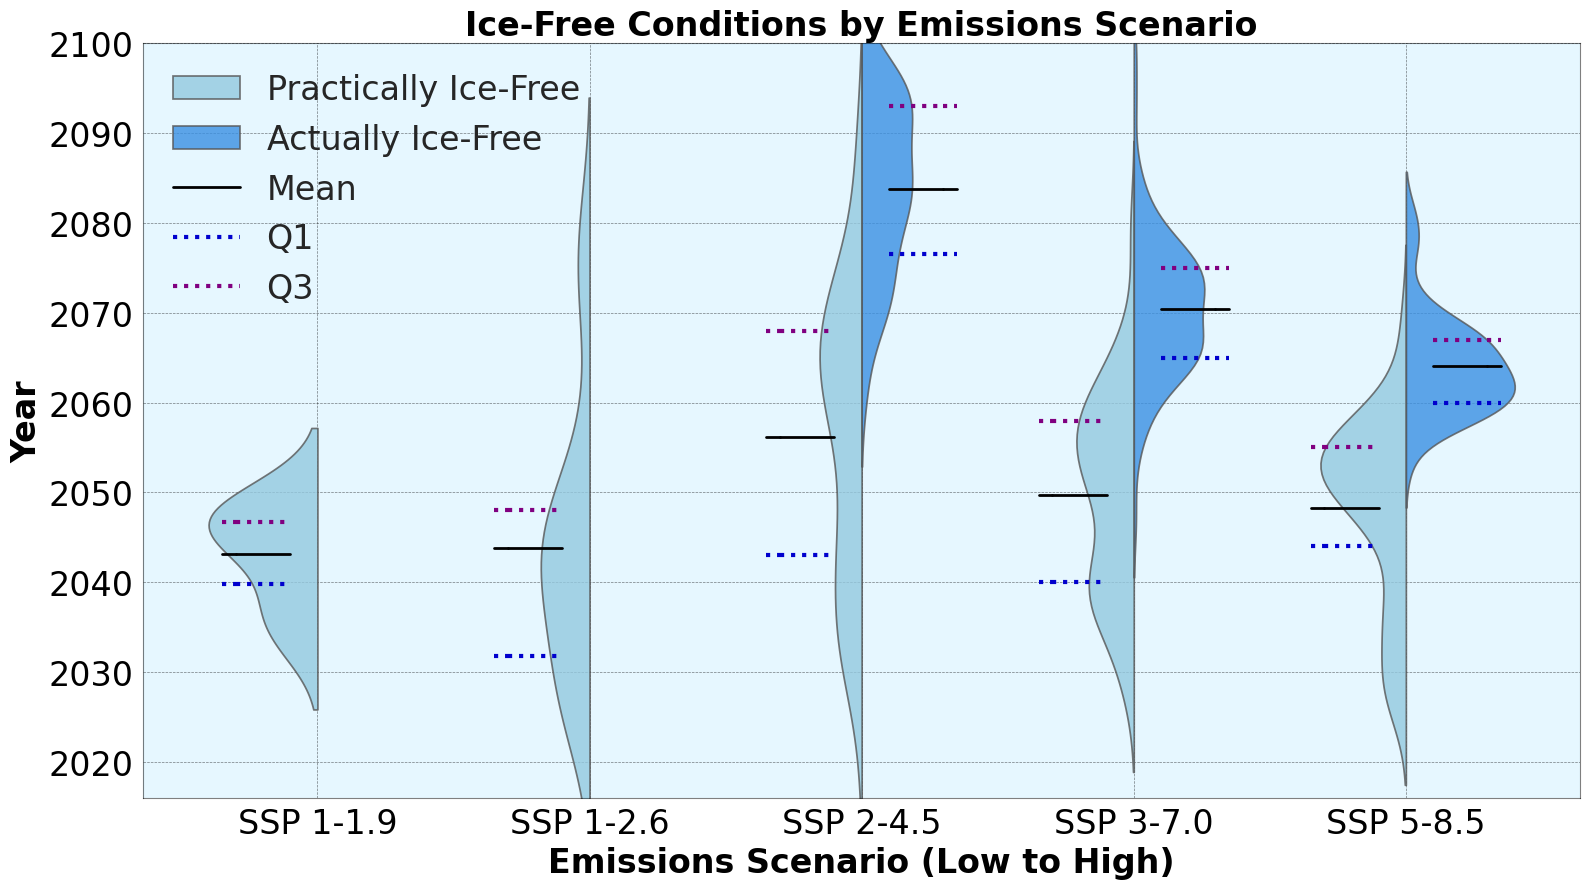

In [7]:
# main.py

def main():
    # Define configuration settings
    config = {
        'debug': False,  # Enable debug mode for detailed output
        'data_path': '/pl/active/courses/2024_fall/ATOC_3700/data/',  # Update this path as needed
        'start_year': '2016-01-01',
        'end_year': '2100-12-31',
        'visualizations': ['violin_plot'],  # Specify which plots to create
        'save_plots': False,  # Set to True to save plots, False to display
        'output_directory': 'plots',  # Directory to save plots
        'color_palette': 'Set2',  # Choose color palette ('Blues', 'viridis', etc.)
        'figure_size': (18, 12)  # Default figure size
    }

    # Initialize and run the simulation
    simulation = SeaIceEnsembleSimulation(config=config)
    simulation.run()

if __name__ == "__main__":
    main()
